In [1]:
# Importing the required libraries for this project. Refer to the .yml file for the full conda environment.
# Standard Python packages we have been using in class: 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

# A package of preset colormaps I prefer to use: 
import cmocean.cm as cmo

# A Stats package which I will be using for my regressions and analysis:
import statsmodels.api as sm
from statsmodels.stats.weightstats import ttest_ind

# Stochastic Analysis of Observations and Reanalysis Precipitation Using a VARX Models

# Chapter 1: Introduction

In my class project, I want to compare an observational dataset and a reanalysis product to see if originate from similar stochastic processes. More specifically, I would like to fit each grid point to a vector autoregressive model with exogeneous variables (VARX). Then using the model fits at each grid point, I can use a likelihood ratio statistic to see if my two datasets are generated from similar statistical processes. In my case I will be comparing an observational dataset with a reanalysis dataset. Verifying whether reanalysis products sufficiently capture the statistics of the real world is very important. 

### Hypothesis: 

I believe that the VARX analysis will show that the reanalysis and observational dataset stem from different statistical processes.

### Data:

I will be employing two datasets for my project: 


##### 1. ECMWF ERA5 monthly averaged data on single levels from 1940 to present

https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=overview

- Variables: Mean Monthly Precipitation Rate [m/day]
- Spatial Resolution: 0.5° x 0.5° [721 x 1440]
- Spatial extent: Global
- Temporal frequency: Monthly
- Temporal extent: 1940 to Present

Brief description: ERA5 is a global reanalysis product combining model forecasts and observations to create a complete dataset. 

 

##### 2. The Global Precipitation Climatology Project (GPCP) Monthly Analysis Product

https://psl.noaa.gov/data/gridded/data.gpcp.html

- Variables: Mean Monthly Precipitation Rate [mm/day]
- Spatial Resolution: 2.5 degree latitude x 2.5 degree longitude global grid [72 x 144]
- Spatial extent: Global
- Temporal frequency: Monthly
- Temporal extent: 1979 to Present

Brief description: A monthly precipitation product that combines satellite, sounding, and land observations from various datasets. A complete dataset, including the global oceans.



Citations: 

1. Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 monthly averaged data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.f17050d7Links to an external site. (Accessed on 10-09-2025)

2. Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P. Xie, J. Janowiak, B. Rudolf, U. Schneider, S. Curtis, D. Bolvin, A. Gruber, J. Susskind, and P. Arkin, 2003: The Version 2 Global Precipitation Climatology Project (GPCP) Monthly Precipitation Analysis (1979-Present). J. Hydrometeor., 4,1147-1167. (Accessed on 10-09-2025)

# Chapter 2: Loading the Data

Since we are using two different datasets, they both need to be processed so they have the same number of grid points, comparable units, etc. This procedure was done in a separate notebook file "Dataset Prep and Interpolation.ipynb" which can be found in Github Repo for this project. Please refer to that file for more detailed information. 

After the procedure is performed, we have two netCDF files from which we can import the datasets. Let us begin!

In [2]:
# Set the file paths for both of my datasets: 
f_path_GPCP = 'gpcp.nc'
f_path_ERA5 = 'era5.nc'

In [3]:
# Load the GPCP Dataset using xarray:
gpcp = xr.load_dataset(f_path_GPCP)
gpcp

<xarray.Dataset> Size: 46MB
Dimensions:    (time: 559, nv: 2, lat: 72, lon: 144)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-07-01
  * lat        (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float32 576B 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 9kB 1979-01-01 ... 2025-08-01
    lat_bnds   (lat, nv) float32 576B -90.0 -87.5 -87.5 -85.0 ... 87.5 87.5 90.0
    lon_bnds   (lon, nv) float32 1kB 0.0 2.5 2.5 5.0 ... 355.0 357.5 357.5 360.0
    precip     (time, lat, lon) float64 46MB 0.0 0.0 0.0 ... 61.39 61.26 61.32
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2025/06 through latest.

In [4]:
# Load the ERA5 Dataset using xarray:
# Note: this one may take some time as the file is large.
era5 = xr.load_dataset(f_path_ERA5)
era5

<xarray.Dataset> Size: 46MB
Dimensions:  (time: 559, lat: 72, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2025-07-01T06:...
  * lat      (lat) float64 576B 88.88 86.38 83.88 81.38 ... -83.62 -86.12 -88.62
  * lon      (lon) float64 1kB 1.125 3.625 6.125 8.625 ... 353.6 356.1 358.6
    number   int64 8B 0
    expver   (time) <U4 9kB '0001' '0001' '0001' '0001' ... '0001' '0001' '0005'
Data variables:
    precip   (time, lat, lon) float64 46MB 10.28 10.11 9.93 ... 5.094 5.086 5.07
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-15T00:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [5]:
# We print the start and end dates for both of our datasets: 
# We want to make sure the time ranges are the same.
print('GPCP Date Range:')
print(gpcp['time'].min().values)
print(gpcp['time'].max().values)

print('\nERA5 Date Range:')
print(era5['time'].min().values)
print(era5['time'].max().values)

GPCP Date Range:
1979-01-01T00:00:00.000000000
2025-07-01T00:00:00.000000000

ERA5 Date Range:
1979-01-01T06:00:00.000000000
2025-07-01T06:00:00.000000000


### Climatology and Anomalies:

To make our lives easier, we will compute the climatology and anomolies for our datasets for future comparisons. 

In [6]:
# Calculate the monthly climatology for the GPCP Dataset: 
gpcp_climo = gpcp.groupby('time.month').mean()
gpcp_climo

<xarray.Dataset> Size: 1MB
Dimensions:    (month: 12, nv: 2, lat: 72, lon: 144)
Coordinates:
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat        (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float32 576B 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
Dimensions without coordinates: nv
Data variables:
    time_bnds  (month, nv) datetime64[ns] 192B 2001-12-31T20:56:10.212765958 ...
    lat_bnds   (month, lat, nv) float32 7kB -90.0 -87.5 -87.5 ... 87.5 87.5 90.0
    lon_bnds   (month, lon, nv) float32 14kB 0.0 2.5 2.5 ... 357.5 357.5 360.0
    precip     (month, lat, lon) float64 995kB 0.7011 0.9593 1.038 ... 12.3 10.9
Attributes: (12/18)
    Conventions:           CF-1.0
    curator:               Dr. Jian-Jian Wang\nESSIC, University of Maryland ...
    citation:              Adler, R.F., G.J. Huffman, A. Chang, R. Ferraro, P...
    title:                 GPCP Version 2.3 Combined Precipitation Dataset (F...
    platform:              NOAA POES (Polar Orbiting Environmental Satellites)
    source_obs:            CDR RSS SSMI/SSMIS Tbs over ocean \nCDR SSMI/SSMIS...
    ...                    ...
    source:                https://www.ncei.noaa.gov/data/global-precipitatio...
    source_documentation:  https://www.ncdc.noaa.gov/cdr/atmospheric/precipit...
    NCO:                   4.6.9
    history:               Generated at NOAA/ESRL PSD Sep 9 2016 based on dat...
    References:            http://www.psl.noaa.gov/data/gridded/data.gpcp.html
    data_comment:          Interim data covers 2025/06 through latest.

In [7]:
# Computing the anomalies for the GPCP Dataset relative to each month:
gpcp_anom = gpcp.groupby('time.month') - gpcp_climo
gpcp_anom

<xarray.Dataset> Size: 47MB
Dimensions:    (lat: 72, lon: 144, time: 559, nv: 2)
Coordinates:
  * lat        (lat) float32 288B -88.75 -86.25 -83.75 ... 83.75 86.25 88.75
  * lon        (lon) float32 576B 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
  * time       (time) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2025-07-01
    month      (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 ... 10 11 12 1 2 3 4 5 6 7
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) timedelta64[ns] 9kB -8401 days +03:03:49.787234042 ...
    lat_bnds   (time, lat, nv) float32 322kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds   (time, lon, nv) float32 644kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip     (time, lat, lon) float64 46MB -0.7011 -0.9593 ... 34.58 34.89

In [8]:
# Calculating the monthly climatology for the ERA5 Dataset:
era5_climo = era5.groupby('time.month').mean()
era5_climo

<xarray.Dataset> Size: 997kB
Dimensions:  (month: 12, lat: 72, lon: 144)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float64 576B 88.88 86.38 83.88 81.38 ... -83.62 -86.12 -88.62
  * lon      (lon) float64 1kB 1.125 3.625 6.125 8.625 ... 353.6 356.1 358.6
    number   int64 8B 0
Data variables:
    precip   (month, lat, lon) float64 995kB 15.33 15.36 15.4 ... 2.588 2.585
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-15T00:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
# Computing the anomalies for the ERA5 Dataset relative to each month:
era5_anom = era5.groupby('time.month') - era5_climo
era5_anom

<xarray.Dataset> Size: 46MB
Dimensions:  (time: 559, lat: 72, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1979-01-01T06:00:00 ... 2025-07-01T06:...
  * lat      (lat) float64 576B 88.88 86.38 83.88 81.38 ... -83.62 -86.12 -88.62
  * lon      (lon) float64 1kB 1.125 3.625 6.125 8.625 ... 353.6 356.1 358.6
    number   (time) int64 4kB 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    expver   (time) <U4 9kB '0001' '0001' '0001' '0001' ... '0001' '0001' '0005'
    month    (time) int64 4kB 1 2 3 4 5 6 7 8 9 10 11 ... 10 11 12 1 2 3 4 5 6 7
Data variables:
    precip   (time, lat, lon) float64 46MB -5.048 -5.259 -5.473 ... 0.487 0.5163

# Chapter 3: Vector Autoregessive Model with Exogeneous Variables (VARX)

For each grid point in both of our datasets, I can extract all the values of it throughout time giving me its time series. I can then take that timeseries and fit it to my VARX model: 

$$ Y_t = Constant + Y_{t-1} + Annual\space Cycles + External\space Forcing\space Trends + Noise\space (\epsilon)$$

#### Constant:
The first regressor in our model is a constant. This can be thought of as the y-intercept of our model. It represents the base value from which our model fluctuates from. 
#### $Y_{t-1}$:
The second parameter $Y_{t-1}$ represent the previous timestep of our timeseries. This regressor should capture the serial correlation of our time series. In other words, it will capture how the current timestep of our timeseries depends on the previous timestep. Here, our timelag is chosen to be one timestep, however, we could choose a longer timestep. Determining the ideal timelag is out of the scope of this project and will not touched upon further. 
and include references/sources
#### Annual Cycles: 
The annual cycles regressors captures the cyclic behavior on annual/season timescales. For instance, if it rains more in the summer, less in the fall in some region, this regressor would model it. These regressors will be composed of Sine and Cosine waves along with several harmonics to capture any wave-like properties that may be occuring over time. In our case, we will go upto the 6th harmonic for both of our sine and cosine waves. However, for frequency 6, our sine waves will have the equation of the form $\sin(\pi t)$ which will return a value of 0 for all our timesteps, and therefore, is dropped from consideration. 
#### External Forcing Trends:
This regressor is meant to capture any long-term trends in our timeseries that may be a result of forcings from greenhouse gases, volcanic activity, forest fires, etc. In our case, these regressors will be orthogonal Legendre polynomials up to the 3rd order. The zero-th order polynomial X^0 is equivalent to our first constant/intercept regressor so it is dropped and not inputed into our fit. 
#### Noise: 
This is the final component of our model and contains all the noise/errors that were not captured by our previous regressors. 

In order to get a good feel for how the modeling procedure works, we can do a quick example with a single timeseries from one of our datasets. 

Text(0.5, 1.0, 'Sample Timeseries $Y_t$')

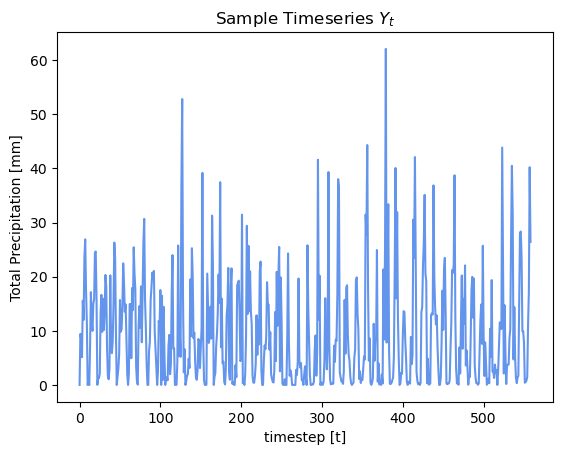

In [10]:
# Extracting the first grid point of the GPCP dataset. 
# This will be used to test the methodology
Yt = np.array(gpcp['precip'][:,0,0].values)

# Plot of the timeseries we extracted:
plt.plot(Yt,'cornflowerblue')
plt.xlabel('timestep [t]')
plt.ylabel('Total Precipitation [mm]')
plt.title('Sample Timeseries $Y_t$')

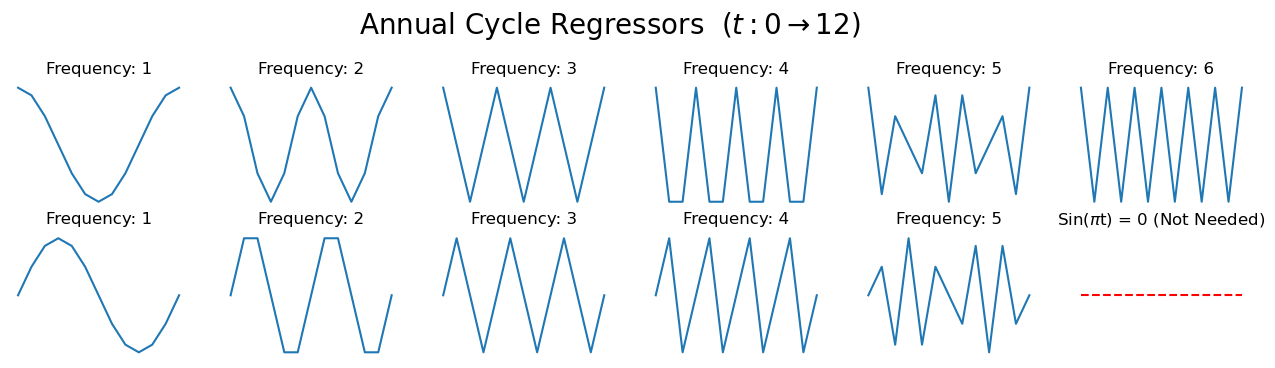

In [11]:
# Create the Annual Cycle regressors for our model fits.

# Define the domain of our regressor using the number of timesteps in our data:
# We want to set the period as 12 b/c we have 12 months.
A = (2 * np.pi * np.arange(gpcp['time'].shape[0])) / 12

# Create empty arrays to store our regressor data:
Hs = np.zeros((5,A.shape[0]))
Hc = np.zeros((6,A.shape[0]))

# Generate the Sine and Cosine regressors:
# We loop to create all the desired harmonics.
for i in np.arange(5):
    Hs[i] = np.sin(A * (i+1) )
    
for i in np.arange(6):
    Hc[i] = np.cos(A * (i+1))

    
# We plot our annual cycle regressors for to double check:
# NOTE: the plots only show the first 12 timesteps or 1 period of the waves.
fig, ax = plt.subplots(2,6, figsize=(16,4))

# Hide plot axes and title the frequency for each harmonic
for i,j in enumerate(Hc): 
    ax[0,i].plot(np.arange(13),j[:13])
    ax[0,i].set_axis_off()
    ax[0,i].set_title('Frequency: ' + str(i+1))

for i,j in enumerate(Hs): 
    ax[1,i].plot(np.arange(13),j[:13])
    ax[1,i].set_axis_off()
    ax[1,i].set_title('Frequency: ' + str(i+1))

# As mentioned before, the 6th harmonic for sine reduces to 0 for all timesteps
# We explicitly show this and make it clear in the plot. 
ax[-1,-1].set_title(r"Sin($\pi$t) = 0 (Not Needed)")
ax[-1,-1].set_axis_off()
ax[-1,-1].plot(np.zeros(12),'r',linestyle='--')

# Put a super title and adjust so its not too close to our plots
fig.suptitle(r'Annual Cycle Regressors  $(t: 0\rightarrow12)$',fontsize=20)
plt.subplots_adjust(top=0.80)

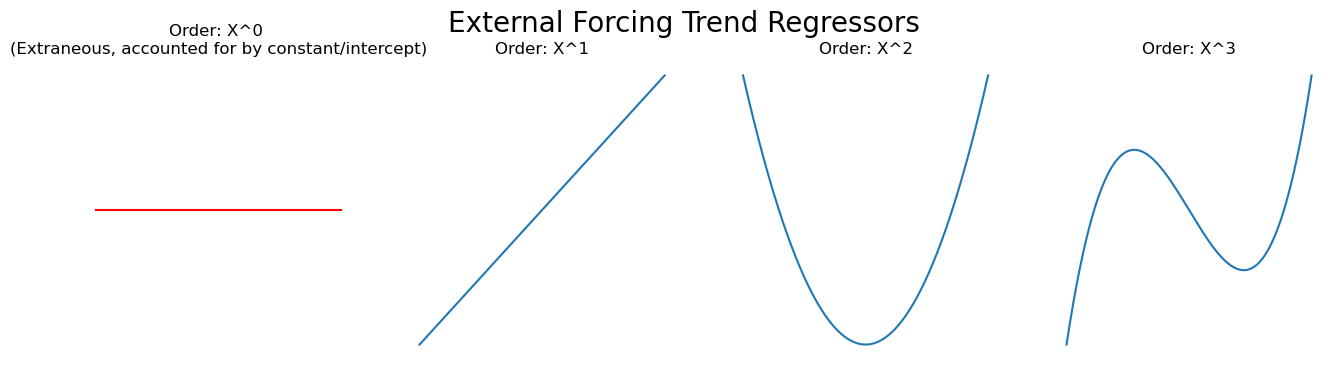

In [12]:
# Create our External Forcing Regressors.

# Define the domain for our orthogonal polynomials:
# NOTE: the domain needs to be -1 to 1, otherwise we only get half the polynomial.
a = np.linspace(-1,1,gpcp['time'].shape[0])

# Create an empty array to store our regressor data:
orthop = np.zeros((4,a.shape[0]))

# We feed the identity matrix into the legval fuction as the coeff of our polynomials.
# This results in us getting the values for each order polynomial separately.
# NOTE: There may be an easier way, I wasn't able to find it in time.
for i,j in enumerate(np.identity(4)): 
    orthop[i] = np.polynomial.legendre.legval(a,j)

# We plot all the regressor to double check:
fig, ax = plt.subplots(1,4, figsize=(16,4))

# Axes is turned off, orders labelled in titles.
for i,j in enumerate(orthop): 
    ax[i].plot(j)
    ax[i].set_axis_off()
    ax[i].set_title('Order: X^' + str(i))
    
# As mentioned before, the zero order polynomial is not needed so we emphasize in the plot.
ax[0].set_title('Order: X^0 \n(Extraneous, accounted for by constant/intercept)')
ax[0].get_lines()[0].set_color('r')

# Super title given and plot positions are adjusted away from title.
fig.suptitle('External Forcing Trend Regressors',fontsize=20)
plt.subplots_adjust(top=0.85)

In [13]:
# Outline the total number of regressor coeff that will be fitted:
print('Constant/Intercept')
print('Yt-1 Autoregressive Coeff')
print(str(Hc.shape[0]) + ' Cosine Harmonic Coeffs')
print(str(Hs.shape[0]) + ' Sine Harmonic Coeffs')
print(str(orthop[1:].shape[0]) + ' Polynomial Coeffs')
print('--------------------------')
print(str(2 + Hc.shape[0] + Hs.shape[0] + orthop[1:].shape[0]) + ' Regressor Coeffs')

# Store the names of all our regressor coeff so they can be used to label our OLS summaries:
xname = ['const','Yt-1','Hc1','Hc2','Hc3','Hc4','Hc5','Hc6','Hs1','Hs2','Hs3','Hs4','Hs5','P1','P2','P3']

Constant/Intercept
Yt-1 Autoregressive Coeff
6 Cosine Harmonic Coeffs
5 Sine Harmonic Coeffs
3 Polynomial Coeffs
--------------------------
16 Regressor Coeffs


#### Regressor Matrix:

We need to create one matrix containing all of our regressor data. Such a matrix, Z, can then be fed into our Ordinary Least Squares solver to obtain our VARX model fit. Since this will be done for each grid point, it would be wise to define Z using a function. Then we could call the function every time we need a new Z array. The function is defined as follows: 

In [14]:
# Define a function return a matrix with all of our regressors:
def getZ(yt):
    "Given timeseries Yt, it returns the regressor matrix"
     
    # all the regressors are vertically stacked and then transposed to get the desired structure: 
    return np.vstack((np.ones(yt.size),
                      yt,
                      Hc,
                      Hs,
                      orthop[1:])).T

In [15]:
# Use the function to obtain the Z matrix for our sample Yt:
Z = getZ(Yt)

# Print the first 3 rows of Z to double-check the structure: 
Z[:3]

array([[ 1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+00,  1.00000000e+00,
        -1.00000000e+00],
       [ 1.00000000e+00,  9.42412674e+00,  8.66025404e-01,
         5.00000000e-01,  6.12323400e-17, -5.00000000e-01,
        -8.66025404e-01, -1.00000000e+00,  5.00000000e-01,
         8.66025404e-01,  1.00000000e+00,  8.66025404e-01,
         5.00000000e-01, -9.96415771e-01,  9.89266582e-01,
        -9.78590859e-01],
       [ 1.00000000e+00,  8.46866432e+00,  5.00000000e-01,
        -5.00000000e-01, -1.00000000e+00, -5.00000000e-01,
         5.00000000e-01,  1.00000000e+00,  8.66025404e-01,
         8.66025404e-01,  1.22464680e-16, -8.66025404e-01,
        -8.66025404e-01, -9.92831541e-01,  9.78571704e-01,
        -9.57373727e-01]])

### Computing the parameters using Ordinary Least Squares: 

Now that we have $Y_t$ and $Z$, we can compute the VARX model fit using a linear regression. However, before we move forward, it is important to note that not all the data will be fed into the regression. In our case, we want to withold the first timestep in our time series, $Y_0$, as our initial conditions that we build off of. Remember, we want to observe any serial correlation, so we will feed $Y_t$ from the second timestep onward. Therefore, we will run the regression with the timeseries Yt[1:]. 

$$ Y_t[1] \Rightarrow Y_t[T]$$ Where T is the total number of timesteps.

Similarly for $Z$, we want to use the previous timestep of $Y_{t-1}$ for each $Y_t$. Therefore, we start $Z$ from index 0 and end at the second to last index.

$$ Z[0] \Rightarrow Z[T-1]$$



In [16]:
# Create our OLS model using Yt and Z:
model = sm.OLS(Yt[1:],Z[:-1])

# set the names for our coeff for ease of use
model.exog_names[:] = xname

# We run our model and show the results:
R = model.fit()
R.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     32.36
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.63e-65
Time:                        18:57:51   Log-Likelihood:                -1900.8
No. Observations:                 558   AIC:                             3834.
Df Residuals:                     542   BIC:                             3903.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7689      0.508     15.279      0.000       6.770       8.768
Yt-1           0.1817      0.042      4.298      0.000       0.099       0.265
Hc1           -7.1267      0.576    -12.374      0.000      -8.258      -5.995
Hc2            2.2357      0.443      5.043      0.000       1.365       3.107
Hc3           -1.0801      0.444     -2.435      0.015      -1.951      -0.209
Hc4            0.3632      0.444      0.819      0.413      -0.508       1.235
Hc5           -0.3181      0.443     -0.718      0.473      -1.189       0.553
Hc6           -0.1596      0.313     -0.509      0.611      -0.775       0.456
Hs1            2.7658      0.454      6.091      0.000       1.874       3.658
Hs2            0.9643      0.457      2.110      0.035       0.067       1.862
Hs3           -0.1397      0.445     -0.314      0.754      -1.015       0.735
Hs4            0.2972      0.443      0.671      0.503      -0.574       1.168
Hs5            0.4873      0.444      1.098      0.273      -0.384       1.359
P1            -0.2995      0.543     -0.551      0.582      -1.367       0.768
P2             1.9439      0.708      2.747      0.006       0.554       3.334
P3            -0.0810      0.829     -0.098      0.922      -1.710       1.548
==============================================================================
Omnibus:                      138.215   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.427
Skew:                           1.176   Prob(JB):                     6.18e-91
Kurtosis:                       6.513   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### SUCCESS!!!
we were able to create a VARX model fit for one grid point from our dataset. The next step would be to fit all the grid points in our dataset. However, before we move on, why don't we plot Yt vs VARX fit and see how well our model matches the initial dataset. As you can see below, it does a good job at capturing most of the timeseries. Though, it seems to have a tough time capturing the extreme values. This is something to look out for going forward.

Text(0.5, 1.0, '$Y_t$ vs VARX Model Fit')

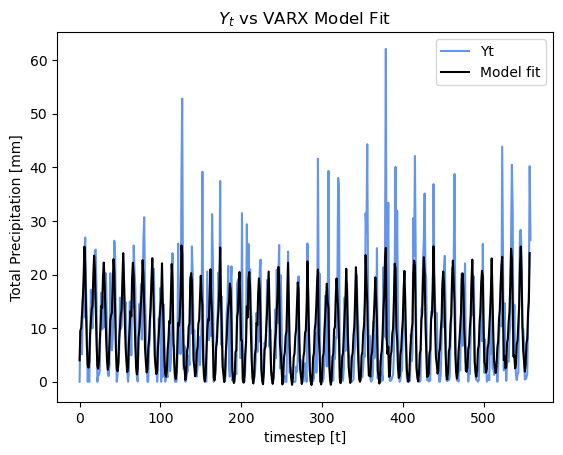

In [17]:
# Plot Yt and our fitted values from OLS:
plt.plot(Yt,'cornflowerblue')
plt.plot(R.fittedvalues,'k')
plt.legend(['Yt', 'Model fit'])
plt.xlabel('timestep [t]')
plt.ylabel('Total Precipitation [mm]')
plt.title('$Y_t$ vs VARX Model Fit')

### Fitting VARX to Anomalies:

Another aspect we can consider is how the VARX would react if we fit it to data where the climatology has been removed. If the VARX is modeling our data correctly, then the annual cycle regressor coefficients should be very small or near zero compared for the anomaly fit. Why don't we try this and see if this works in practice.

Text(0.5, 1.0, '$Y_t$ - Climatology')

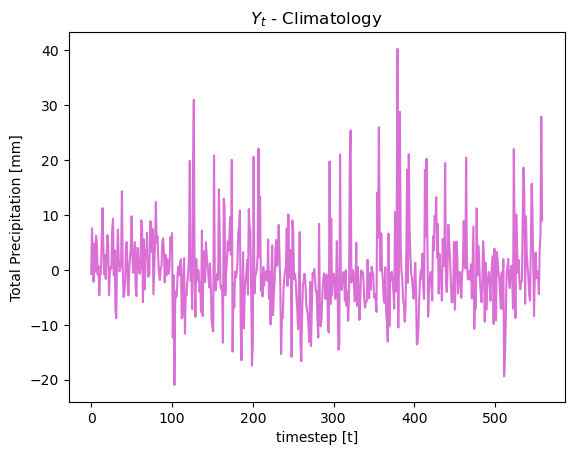

In [18]:
# Define the same grid point using our previously computed anomalies:
Yt_anom = np.array(gpcp_anom['precip'][:,0,0].values)

# Plot Yt_anom
plt.plot(Yt_anom,'orchid')
plt.xlabel('timestep [t]')
plt.ylabel('Total Precipitation [mm]')
plt.title('$Y_t$ - Climatology')

In [19]:
# Create our regressor matrix for Yt_anom:
Z_anom = getZ(Yt_anom)

# Create our OLS model using Yt_anom and Z_anom:
model = sm.OLS(Yt_anom[1:],Z_anom[:-1])

# set the names for our coeff for ease of use
model.exog_names[:] = xname

# Compute our OLS fit and show our results:
R_anom = model.fit()
R_anom.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2.020
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0126
Time:                        18:57:53   Log-Likelihood:                -1900.8
No. Observations:                 558   AIC:                             3834.
Df Residuals:                     542   BIC:                             3903.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.313      0.012      0.990      -0.612       0.619
Yt-1           0.1817      0.042      4.298      0.000       0.099       0.265
Hc1           -0.0107      0.443     -0.024      0.981      -0.881       0.860
Hc2            0.0057      0.443      0.013      0.990      -0.865       0.876
Hc3           -0.0129      0.443     -0.029      0.977      -0.884       0.858
Hc4            0.0032      0.443      0.007      0.994      -0.868       0.874
Hc5           -0.0151      0.443     -0.034      0.973      -0.886       0.856
Hc6            0.0010      0.313      0.003      0.997      -0.615       0.617
Hs1           -0.0273      0.443     -0.062      0.951      -0.898       0.844
Hs2           -0.0046      0.443     -0.010      0.992      -0.875       0.866
Hs3           -0.0095      0.443     -0.021      0.983      -0.880       0.861
Hs4           -0.0030      0.443     -0.007      0.995      -0.874       0.868
Hs5           -0.0031      0.443     -0.007      0.994      -0.874       0.868
P1            -0.2995      0.543     -0.551      0.582      -1.367       0.768
P2             1.9439      0.708      2.747      0.006       0.554       3.334
P3            -0.0810      0.829     -0.098      0.922      -1.710       1.548
==============================================================================
Omnibus:                      138.215   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.427
Skew:                           1.176   Prob(JB):                     6.18e-91
Kurtosis:                       6.513   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### SUCCESS AGAIN!!!
Just as we predicited, the VARX model produced annual cycle coefficients (Hc and Hs) that are near zero. You can see a visualization of the fit below. 

Text(0.5, 1.0, '$Y_t$ Anomaly vs VARX Model Fit')

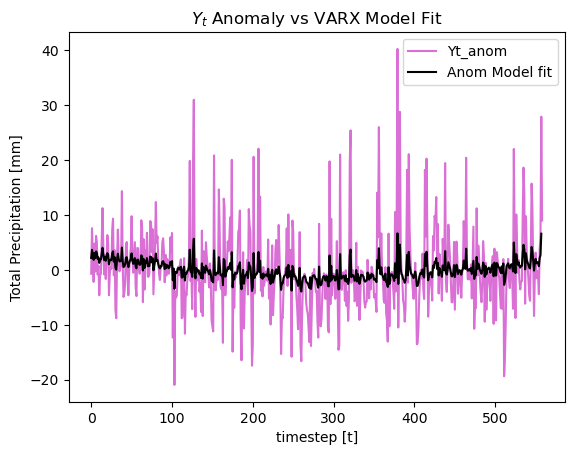

In [20]:
# Plot Yt_anom and our fitted values from OLS:
plt.plot(Yt_anom,'orchid')
plt.plot(R_anom.fittedvalues,'k')
plt.legend(['Yt_anom', 'Anom Model fit'])
plt.xlabel('timestep [t]')
plt.ylabel('Total Precipitation [mm]')
plt.title('$Y_t$ Anomaly vs VARX Model Fit')

# Chapter 4: Applying VARX Model Fits to Datasets

Now that we have successfully applied the VARX model to a grid point, it is time that we apply the VARX to all the grid points for both datasets. The most straight-forward approach is to use two for loops. In the for loop, we need to extract the timeseries for each grid point, define the Z matrix, run the OLS fit, and then store the results in an appropriate array. To get started lets create an empty array to store our results. 

In [21]:
# Lets remind ourselves the shape of our dataset:
gpcp['precip'].shape

(559, 72, 144)

In [22]:
# Create an empty array that can be used to store the OLS fits:
# NOTE: the dtype needs to be set to object, otherwise it will expect to recieve numbers.
GPCP_Model_Fits = np.empty(gpcp['precip'].shape[1:],dtype='object')

In [23]:
# Main loop that iterates through each row of the dataset.
for i in np.arange(GPCP_Model_Fits.shape[0]):
    
    # print the rows to track the progress of the calculation.
    print(i)
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(GPCP_Model_Fits.shape[1]):
        
        # Extracts the timeseries at current grid point:
        yt = np.array(gpcp['precip'][:,i,j].values)
    
        # Define the Z matrix for the grid point: 
        z = getZ(yt)
    
        # Create the OLS model for the grid point:
        model = sm.OLS(yt[1:],z[:-1])
        
        # Set the regressor names for ease of analysis.
        model.exog_names[:] = xname
        
        # Run the model fit and store it in the previously created array:
        GPCP_Model_Fits[i,j] = model.fit()
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [24]:
# Sample OLS model fit output:
GPCP_Model_Fits[0,0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     32.36
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           1.63e-65
Time:                        18:58:32   Log-Likelihood:                -1900.8
No. Observations:                 558   AIC:                             3834.
Df Residuals:                     542   BIC:                             3903.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7689      0.508     15.279      0.000       6.770       8.768
Yt-1           0.1817      0.042      4.298      0.000       0.099       0.265
Hc1           -7.1267      0.576    -12.374      0.000      -8.258      -5.995
Hc2            2.2357      0.443      5.043      0.000       1.365       3.107
Hc3           -1.0801      0.444     -2.435      0.015      -1.951      -0.209
Hc4            0.3632      0.444      0.819      0.413      -0.508       1.235
Hc5           -0.3181      0.443     -0.718      0.473      -1.189       0.553
Hc6           -0.1596      0.313     -0.509      0.611      -0.775       0.456
Hs1            2.7658      0.454      6.091      0.000       1.874       3.658
Hs2            0.9643      0.457      2.110      0.035       0.067       1.862
Hs3           -0.1397      0.445     -0.314      0.754      -1.015       0.735
Hs4            0.2972      0.443      0.671      0.503      -0.574       1.168
Hs5            0.4873      0.444      1.098      0.273      -0.384       1.359
P1            -0.2995      0.543     -0.551      0.582      -1.367       0.768
P2             1.9439      0.708      2.747      0.006       0.554       3.334
P3            -0.0810      0.829     -0.098      0.922      -1.710       1.548
==============================================================================
Omnibus:                      138.215   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.427
Skew:                           1.176   Prob(JB):                     6.18e-91
Kurtosis:                       6.513   Cond. No.                         36.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# Now we repeat the same procedure of ERA5
# Double-check the shape of ERA5
era5['precip'].shape

(559, 72, 144)

In [26]:
# Create an empty array that can be used to store the OLS fits:
# NOTE: the dtype needs to be set to object, otherwise it will expect to recieve numbers
ERA5_Model_Fits = np.empty(era5['precip'].shape[1:],dtype='object')

In [27]:
# Main loop that iterates through each row of the dataset.
for i in np.arange(ERA5_Model_Fits.shape[0]):
    
    # print the rows to track the progress of the calculation.
    print(i)
    
    # The secondary loop that iterates through all column elements in each row.
    for j in np.arange(ERA5_Model_Fits.shape[1]):
        
        # Extracts the timeseries at current grid point:
        yt = np.array(era5['precip'][:,i,j].values)
    
        # Define the Z matrix for the grid point: 
        z = getZ(yt)
    
        # Create the OLS model for the grid point:
        model = sm.OLS(yt[1:],z[:-1])
        
        # Set the regressor names for ease of analysis.
        model.exog_names[:] = xname
        
        # Run the model fit and store it in the previously created array:
        ERA5_Model_Fits[i,j] = model.fit()
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [28]:
# Sample OLS model fit output:
ERA5_Model_Fits[0,0].summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     34.38
Date:                Thu, 04 Dec 2025   Prob (F-statistic):           7.56e-69
Time:                        18:59:54   Log-Likelihood:                -1953.2
No. Observations:                 558   AIC:                             3938.
Df Residuals:                     542   BIC:                             4008.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.1234      0.980     19.510      0.000      17.198      21.049
Yt-1           0.1106      0.043      2.587      0.010       0.027       0.195
Hc1           -9.3766      0.614    -15.262      0.000     -10.583      -8.170
Hc2            3.1620      0.494      6.405      0.000       2.192       4.132
Hc3           -0.4879      0.488     -0.999      0.318      -1.447       0.471
Hc4           -0.2175      0.488     -0.446      0.656      -1.176       0.741
Hc5           -0.2242      0.487     -0.460      0.645      -1.181       0.732
Hc6           -0.4222      0.345     -1.225      0.221      -1.099       0.255
Hs1            0.2530      0.540      0.468      0.640      -0.809       1.315
Hs2           -0.6218      0.501     -1.241      0.215      -1.606       0.363
Hs3           -0.7940      0.487     -1.630      0.104      -1.751       0.163
Hs4            0.9297      0.488      1.906      0.057      -0.029       1.888
Hs5            0.0879      0.487      0.180      0.857      -0.869       1.045
P1             0.4100      0.597      0.687      0.492      -0.762       1.582
P2             0.5183      0.770      0.673      0.501      -0.995       2.032
P3            -0.4181      0.911     -0.459      0.647      -2.208       1.372
==============================================================================
Omnibus:                       73.778   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              140.200
Skew:                           0.779   Prob(JB):                     3.60e-31
Kurtosis:                       4.898   Cond. No.                         77.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Values of Model Fits:

For ease of use later, let us extract all the fitted values for each grid point and store them in an array. We can extract the values using a similar for loop set up. As we did before, let us initialize an empty array and then start assigning values to it. We can use the original shape of our dataset similar to before.

##### NOTE: Our OLS fits have 558 timesteps instead of 559, because we used the skipped the first timestep to define our $Y_{t-1}$ regressor. Therefore, we need to assign the values to our empty array more carefully.

In [29]:
# Create an empty array that can be used to store the OLS values:
# NOTE: np.zeros is used so we have zeros for values that don't get filled in. (useful later)
GPCP_Model_Values = np.zeros(gpcp['precip'].shape)

# Display to shape to double-check:
GPCP_Model_Values.shape

(559, 72, 144)

In [30]:
# Display the shape of our fitted values:
GPCP_Model_Fits[0,0].fittedvalues.shape

(558,)

In [31]:
# Main loop that iterates through each row of our OLS fits array:
for i in np.arange(GPCP_Model_Values.shape[1]):
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(GPCP_Model_Values.shape[2]):
        
        # Extract the model fit values and store them in the previously created array:
        # NOTE: we skip the first timestep to match the shape of our fitted values.
        GPCP_Model_Values[1:,i,j] = GPCP_Model_Fits[i,j].fittedvalues

# Display our finished array:
# NOTE: if we assigned our values correctly, then first timestep should be all zeros.
GPCP_Model_Values

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 4.00766805,  4.02484158,  4.15410244, ...,  3.68934659,
          4.11482376,  4.63370512],
        [ 2.83153956,  3.39919619,  3.62369326, ...,  2.87640167,
          3.19485209,  3.35142969],
        [ 2.30276328,  3.03045271,  3.02245552, ...,  2.72932303,
          3.39769738,  2.67120782],
        ...,
        [18.95466387, 19.17301331, 17.8205512 , ..., 1

In [32]:
# We repeat the same procedure for the ERA5 Model fits:

# Create an empty array that can be used to store the OLS values:
# NOTE: np.zeros is used so we have zeros for values that don't get filled in. (useful later)
ERA5_Model_Values = np.zeros(era5['precip'].shape)

# Main loop that iterates through each row of our OLS fits array:
for i in np.arange(ERA5_Model_Values.shape[1]):
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(ERA5_Model_Values.shape[2]):
        
        # Extract the model fit values and store them in the previously created array:
        # NOTE: we skip the first timestep to match the shape of our fitted values.
        ERA5_Model_Values[1:,i,j] = ERA5_Model_Fits[i,j].fittedvalues

# Display our finished array:
# NOTE: if we assigned our values correctly, then first timestep should be all zeros.
ERA5_Model_Values

array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[13.22043886, 13.12209613, 13.02418781, ..., 13.44344249,
         13.3779051 , 13.30519697],
        [17.97056475, 17.58276998, 17.20877188, ..., 18.88566337,
         18.73156556, 18.36194015],
        [20.91438371, 20.3222383 , 19.83036364, ..., 22.70257894,
         22.35570011, 21.69922425],
        ...,
        [ 2.83176248,  2.69593778,  2.56328394, ...,  

Text(0.5, 0.98, 'Dataset Comparison May-1987')

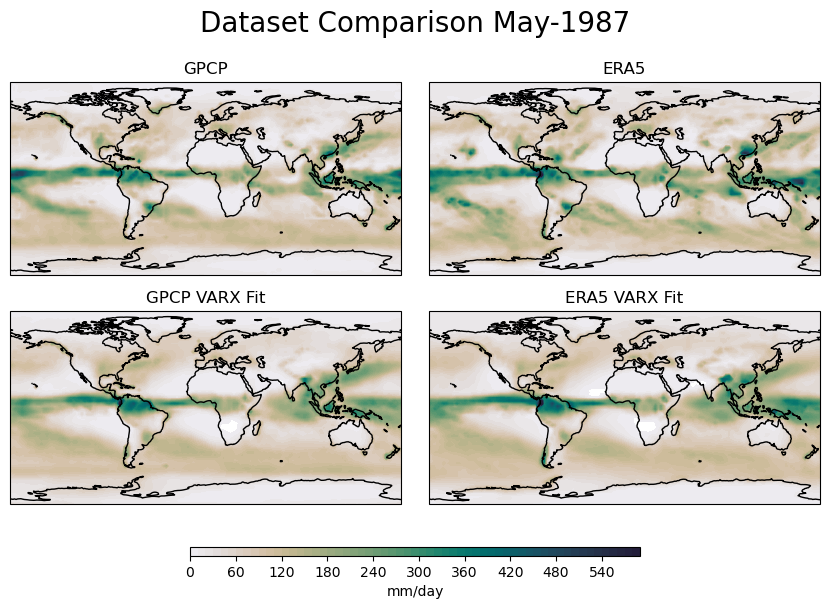

In [33]:
# Plot all four datasets at given timestep. In this case I chose index 100.

# Define all 4 timeseries at index 100 in one list:
H = [gpcp['precip'][100], era5['precip'][100], GPCP_Model_Values[100], ERA5_Model_Values[100]]
Hn = ['GPCP','ERA5','GPCP VARX Fit','ERA5 VARX Fit']
clevs = np.arange(0,600,10)

fig, ax = plt.subplots(2,2,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(9,7))

ax = ax.flatten()

for i in np.arange(2):

    data = H[i]

    data,lons = add_cyclic_point(data,coord=H[i]['lon'])

    cs = ax[i].contourf(lons,H[i]['lat'],data,clevs,
                       transform = ccrs.PlateCarree(),
                       cmap=cmo.rain)
    
    # Draw the coastines for each subplot
    ax[i].coastlines()
    
    ax[i].set_title(Hn[i])
    
for i in np.arange(2):

    data = H[i+2]

    data,lons = add_cyclic_point(data,coord=H[i]['lon'])

    cs = ax[i+2].contourf(lons,H[i]['lat'],data,clevs,
                       transform = ccrs.PlateCarree(),
                       cmap=cmo.rain)
    
    # Draw the coastines for each subplot
    ax[i+2].coastlines()
    
    ax[i+2].set_title(Hn[i+2])

fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.07, hspace=0.01)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.2, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')
    
fig.suptitle('Dataset Comparison ' + str(H[0].time.dt.strftime("%B-%Y").item()),fontsize = 20)

# plt.savefig('Dataset Comparison May 1987.png')

# Chapter 5: Stocastic Analysis

Now that we have created the VARX fits for both datasets at each grid point, we can use a statistic to test whether these two dataset orginate from the same statistical processes. The test I will use is the log-likelihood ratio statistic. Setting $Y_{t1}$ as the timeseries from the first dataset and $Y_{t2}$ as the timeseries from the second dataset, then the formula is as follows: 

$$\Huge{ \Lambda = e^{\ell_{H_0} - \ell_H}}$$

where $\ell_{H_0}$ is the log-likelihood given both $Y_{t1}$ and $Y_{t2}$ $(\ell_{H_0} = \ell(Y_{t1} + Y_{t2}))$ and $\ell_H$ is the sum of the log-likelihoods of $Y_{t1}$ and $Y_{t2}$ $(\ell_{H} = \ell(Y_{t1}) + \ell(Y_{t2}))$. We can rewrite the equation using the logorithm and have: 

$$\huge{\ln(\Lambda) = \ell_{H_0} - \ell_H}$$

If our dataset originates from the same statistical processes, then $\ln(\Lambda)$ will be near zero. But if they differ, then the values should be positive. Our OLS fits also provide us the values for the Log-likelihood in the .llf method. However, if we would like to get the log-likelihood of our null hypothesis this way, we would need to fit the joint data at each grid point. A shortcut to evaluating the null hypothesis $\ell_{H_0}$ can be done using the following formula:

$$\Large{\ell_{H_0} = -\frac{T_1 + T_2}{2}[1 + \log(2\pi) + \log(\frac{S_1 + S_2}{T_1 + T_2})] }$$

Where $T_1$ and $T_2$ are number of timesteps in for your respective timeseries, and $S_1$ and $S_2$ are the sum of the squared residuals (errors) of your respective timeseries. The best place to start is to define a function that can compute the formula above. 

In [34]:
# given sum square errors and the number of timesteps, it computes the Maximum log-likelihood:
def MLogL(SSR, Ti): 
    "float: (SSR, Ti)\nCalculates the Maximized Log-likelihood using sum of squared residuals (aka residual sum of squares) and total number of timesteps (number of observations)."
    
    return -(Ti/2) * (1 + np.log(2*np.pi) + np.log(SSR/Ti))

In [35]:
# Create an empty array that can be used to store the OLS values:
# NOTE: np.zeros is used so we have zeros for values that don't get filled in. (useful later)
GPCP_Model_Likelihood = np.zeros(gpcp['precip'].shape[1:])

# Display to shape to double-check:
GPCP_Model_Likelihood.shape

(72, 144)

In [51]:
# How to extract the log-likelihood of our fitted values:
GPCP_Model_Fits[0,0].llf

np.float64(-1900.7522348970106)

In [37]:
# Main loop that iterates through each row of our OLS fits array:
for i in np.arange(GPCP_Model_Likelihood.shape[0]):
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(GPCP_Model_Likelihood.shape[1]):
        
        # Extract the model fit values and store them in the previously created array:
        # NOTE: we skip the first timestep to match the shape of our fitted values.
        GPCP_Model_Likelihood[i,j] = GPCP_Model_Fits[i,j].llf

# Display our finished array:
# NOTE: if we assigned our values correctly, then first timestep should be all zeros.
GPCP_Model_Likelihood

array([[-1900.7522349 , -1899.50516716, -1894.02063173, ...,
        -1906.74041511, -1919.82273333, -1916.26887312],
       [-1777.61586583, -1765.65002121, -1762.19878421, ...,
        -1802.7611779 , -1793.25753272, -1795.35319279],
       [-1766.99923727, -1744.30915506, -1693.52285563, ...,
        -1787.08968891, -1796.85810945, -1786.00989404],
       ...,
       [-2031.88153242, -2022.59611543, -2027.11434094, ...,
        -2049.66278645, -2048.87099185, -2033.04312426],
       [-2055.28780016, -2056.81521867, -2056.21458997, ...,
        -2058.26426388, -2057.34734282, -2060.6309259 ],
       [-2142.07889398, -2152.70379146, -2136.66729848, ...,
        -2160.31854619, -2146.17229033, -2148.1743805 ]])

In [38]:
# We repeat the same procedure for the ERA5 Model fits:

# Create an empty array that can be used to store the OLS values:
# NOTE: np.zeros is used so we have zeros for values that don't get filled in. (useful later)
ERA5_Model_Likelihood = np.zeros(era5['precip'].shape[1:])

# Main loop that iterates through each row of our OLS fits array:
for i in np.arange(ERA5_Model_Likelihood.shape[0]):
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(ERA5_Model_Likelihood.shape[1]):
        
        # Extract the model fit values and store them in the previously created array:
        # NOTE: we skip the first timestep to match the shape of our fitted values.
        ERA5_Model_Likelihood[i,j] = ERA5_Model_Fits[i,j].llf

# Display our finished array:
# NOTE: if we assigned our values correctly, then first timestep should be all zeros.
ERA5_Model_Likelihood

array([[-1953.20558331, -1953.79830457, -1954.6086264 , ...,
        -1950.21415824, -1951.14236482, -1952.29520391],
       [-2008.15191626, -2004.5161476 , -2000.20694813, ...,
        -2010.18166185, -2010.63122799, -2009.82788481],
       [-2117.07101006, -2100.36476843, -2085.63620234, ...,
        -2159.59020043, -2147.59190601, -2134.24246964],
       ...,
       [-1259.75998092, -1208.2998684 , -1156.68110917, ...,
        -1375.38808989, -1345.47082164, -1306.86884937],
       [-1187.55245545, -1176.2238509 , -1164.99445458, ...,
        -1234.06579077, -1215.20722285, -1200.45885317],
       [-1288.93089696, -1284.2307128 , -1279.51594488, ...,
        -1300.11849036, -1296.36143176, -1292.75161503]])

In [39]:
# Create an empty array that can be used to store the OLS values:
# NOTE: np.zeros is used so we have zeros for values that don't get filled in. (useful later)
GPCP_Model_SSR = np.zeros(gpcp['precip'].shape[1:])

# Main loop that iterates through each row of our OLS fits array:
for i in np.arange(GPCP_Model_SSR.shape[0]):
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(GPCP_Model_SSR.shape[1]):
        
        # Extract the model fit values and store them in the previously created array:
        # NOTE: we skip the first timestep to match the shape of our fitted values.
        GPCP_Model_SSR[i,j] = GPCP_Model_Fits[i,j].ssr

# Display our finished array:
# NOTE: if we assigned our values correctly, then first timestep should be all zeros.
GPCP_Model_SSR

array([[29709.25584024, 29576.75843385, 29001.02087062, ...,
        30353.79810706, 31810.98539101, 31408.3516122 ],
       [19108.04878459, 18305.86163845, 18080.81247191, ...,
        20910.18195471, 20209.90783041, 20362.28259714],
       [18394.60134734, 16957.84836423, 14135.66462605, ...,
        19768.03034574, 20472.41282026, 19691.67133066],
       ...,
       [47534.5171454 , 45978.55349406, 46729.20837005, ...,
        50662.6127345 , 50519.03741148, 47732.83545909],
       [51694.40507616, 51978.18830751, 51866.41048994, ...,
        52248.85022652, 52077.41856518, 52693.94456005],
       [70557.55402608, 73296.35025376, 69202.17870555, ...,
        75324.37920863, 71600.3825955 , 72116.03131406]])

In [40]:
# We repeat the same procedure for the ERA5 Model fits:

# Create an empty array that can be used to store the OLS values:
# NOTE: np.zeros is used so we have zeros for values that don't get filled in. (useful later)
ERA5_Model_SSR = np.zeros(era5['precip'].shape[1:])

# Main loop that iterates through each row of our OLS fits array:
for i in np.arange(ERA5_Model_SSR.shape[0]):
    
    # The secondary loop that iterates through all column elements in each row. 
    for j in np.arange(ERA5_Model_SSR.shape[1]):
        
        # Extract the model fit values and store them in the previously created array:
        # NOTE: we skip the first timestep to match the shape of our fitted values.
        ERA5_Model_SSR[i,j] = ERA5_Model_Fits[i,j].ssr

# Display our finished array:
# NOTE: if we assigned our values correctly, then first timestep should be all zeros.
ERA5_Model_SSR

array([[35854.29894849, 35930.55054416, 36035.05818299, ...,
        35471.92438072, 35590.13263938, 35737.49672989],
       [43658.75069086, 43093.50575893, 42433.03337403, ...,
        43977.52948793, 44048.44972238, 43921.80052534],
       [64508.35520002, 60759.03230792, 57634.72160214, ...,
        75127.99697204, 71965.63012649, 68603.33875904],
       ...,
       [ 2986.18115619,  2483.20612625,  2063.77544182, ...,
         4519.64310824,  4060.08000956,  3535.46331798],
       [ 2305.24515978,  2213.51713303,  2126.19496562, ...,
         2723.45554316,  2545.45155075,  2414.38964656],
       [ 3315.30829867,  3259.92465198,  3205.29866252, ...,
         3450.94988289,  3404.79033358,  3361.02151619]])

In [45]:
Lh1 = GPCP_Model_Likelihood + ERA5_Model_Likelihood
Lh1

array([[-3853.95781821, -3853.30347173, -3848.62925813, ...,
        -3856.95457335, -3870.96509815, -3868.56407703],
       [-3785.76778209, -3770.16616881, -3762.40573233, ...,
        -3812.94283976, -3803.88876071, -3805.1810776 ],
       [-3884.07024733, -3844.67392349, -3779.15905797, ...,
        -3946.67988934, -3944.45001546, -3920.25236368],
       ...,
       [-3291.64151334, -3230.89598383, -3183.79545011, ...,
        -3425.05087634, -3394.34181349, -3339.91197363],
       [-3242.84025561, -3233.03906957, -3221.20904456, ...,
        -3292.33005464, -3272.55456566, -3261.08977907],
       [-3431.00979093, -3436.93450425, -3416.18324336, ...,
        -3460.43703655, -3442.5337221 , -3440.92599554]])

In [46]:
Lh0 = MLogL(GPCP_Model_SSR+ERA5_Model_SSR,558+558)
Lh0

array([[-3856.41956664, -3855.94066288, -3851.91215644, ...,
        -3858.64638108, -3871.84359699, -3869.72625966],
       [-3832.09427567, -3819.80335989, -3811.69710623, ...,
        -3850.63772991, -3845.199202  , -3845.4225503 ],
       [-3987.35468581, -3951.30886941, -3906.8917651 , ...,
        -4062.74668934, -4048.10296764, -4022.51586705],
       ...,
       [-3710.98420174, -3687.7668852 , -3691.56770369, ...,
        -3760.23234978, -3754.09987135, -3719.18093378],
       [-3748.14390471, -3750.12496717, -3748.07110343, ...,
        -3758.10529701, -3754.54700616, -3759.48435706],
       [-3923.00323169, -3942.91297923, -3911.82316249, ...,
        -3958.85714578, -3931.49127359, -3934.99082108]])

In [42]:
nullH = MLogL(GPCP_Model_SSR+ERA5_Model_SSR,558+558) - (GPCP_Model_Likelihood + ERA5_Model_Likelihood)
nullH

array([[  -2.46174843,   -2.63719116,   -3.28289831, ...,   -1.69180773,
          -0.87849884,   -1.16218263],
       [ -46.32649358,  -49.63719108,  -49.2913739 , ...,  -37.69489015,
         -41.31044129,  -40.2414727 ],
       [-103.28443848, -106.63494592, -127.73270714, ..., -116.0668    ,
        -103.65295219, -102.26350338],
       ...,
       [-419.3426884 , -456.87090137, -507.77225358, ..., -335.18147344,
        -359.75805787, -379.26896015],
       [-505.3036491 , -517.0858976 , -526.86205887, ..., -465.77524237,
        -481.9924405 , -498.39457799],
       [-491.99344075, -505.97847498, -495.63991913, ..., -498.42010922,
        -488.95755149, -494.06482554]])

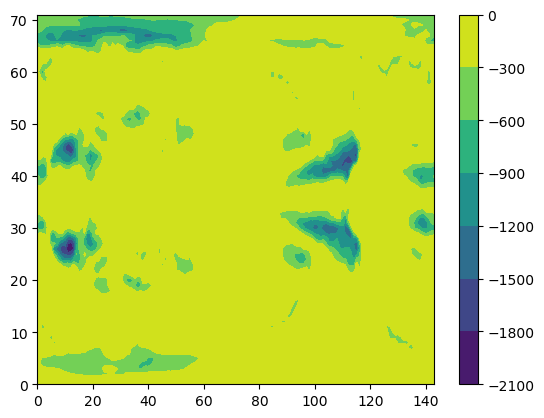

In [43]:
plt.contourf(nullH)
plt.colorbar()

In [ ]:
fig,ax = plt.subplots(1,1,
                   subplot_kw={'projection': ccrs.PlateCarree()},
                   figsize=(7,7))

data = H[0]

data,lons = add_cyclic_point(data,coord=H[0]['lon'])

cs = ax.contourf(lons,H[0]['lat'],stat,clevs,
                       transform = ccrs.PlateCarree(),
                       cmap=cmo.rain)
    
# Draw the coastines for each subplot
ax.coastlines()
    
# ax.set_title(Hn[i+2])


ax.coastlines()

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.25, 0.18, 0.5, 0.012])

# Draw the colorbar
cbar = fig.colorbar(cs,cax=cbar_ax,orientation='horizontal',label='mm/day')